db에서 불러오기

In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
# from sqlalchemy import create_engine

In [ ]:
# 1. 데이터베이스 연결 -> 연결 객체 반환
conn = pymysql.connect(host="localhost", port=3306, db="mp",
                       user="root", passwd="1234", cursorclass=pymysql.cursors.DictCursor)

cursor = conn.cursor()

In [ ]:
# 3. SQL 작성 + 명령 실행 ( 조회 명령 )
sql = """select * from fine_dust"""
cursor.execute(sql)
result = cursor.fetchall()
result

In [ ]:
fine_dust_df = pd.DataFrame(result)
fine_dust_df.head()

In [ ]:
conn.close()
cursor.close()

In [ ]:
fine_dust_df.to_csv('./data/fine_dust.csv')

### db 종료 후 DF으로 작업하기 (여기서부터 시작)

In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
# from sqlalchemy import create_engine

# !pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


In [3]:
fine_dust_df = pd.read_csv('./data/fine_dust.csv')
fine_dust_df.columns

Index(['Unnamed: 0', 'station_id', 'station_name', 'date', 'fine_dust(㎍/㎥)'], dtype='object')

In [4]:
# 필요 컬럼만 자르기
fine_dust = fine_dust_df.loc[:, ['date', 'fine_dust(㎍/㎥)']] # 잘랐으면 비활성화 안 잘랐으면 활성화
fine_dust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1323 non-null   object
 1   fine_dust(㎍/㎥)  1323 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.8+ KB


In [5]:
# 좋음 (0-30 ㎍/m³) → Good
# 보통 (31-80 ㎍/m³) → Moderate
# 나쁨 (81-150 ㎍/m³) → Bad
# 매우 나쁨 (151 ㎍/m³ 이상) → Very Bad

# 새로운 컬럼을 생성하고 조건에 따라 값 입력

conditionlist = [
    (fine_dust['fine_dust(㎍/㎥)'] <= 30),
    (fine_dust['fine_dust(㎍/㎥)'] > 30) & (fine_dust['fine_dust(㎍/㎥)'] <= 80),
    (fine_dust['fine_dust(㎍/㎥)'] > 80) & (fine_dust['fine_dust(㎍/㎥)'] <= 150),
    (fine_dust['fine_dust(㎍/㎥)'] > 150),
]

values = ['good', 'normal', 'bad', 'very_bad']

fine_dust["grade"] = np.select(conditionlist, values, default="unknown")
fine_dust.head(2)

,date,fine_dust(㎍/㎥),grade
0,2021-01-01,36,normal
1,2021-01-02,43,normal


fine_dust의 date의 타입 변경 후 평일/주말 나누기

In [6]:
fine_dust.info() # date 타입이 object임을 확인
fine_dust['date'] = pd.to_datetime(fine_dust['date'])
# fine_dust.info() # date타입이 datetime64[ns]으로 변경됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1323 non-null   object
 1   fine_dust(㎍/㎥)  1323 non-null   int64 
 2   grade           1323 non-null   object
dtypes: int64(1), object(2)
memory usage: 31.1+ KB


In [7]:
# fine_dust["date"]에 따라 평일, 주말 나누기(월~금 : 0~4, 토일 : 5, 6)
fine_dust["day"] = np.where(fine_dust["date"].dt.weekday < 5, "weekday", "weekend")
fine_dust


,date,fine_dust(㎍/㎥),grade,day
0,2021-01-01,36,normal,weekday
1,2021-01-02,43,normal,weekend
2,2021-01-03,47,normal,weekend
3,2021-01-04,50,normal,weekday
4,2021-01-05,37,normal,weekday
...,...,...,...,...
1318,2024-10-25,29,good,weekday
1319,2024-10-26,26,good,weekend
1320,2024-10-27,27,good,weekend
1321,2024-10-28,38,normal,weekday


공휴일 데이터인 hd의 date의 타입 변경

In [8]:
hd = pd.read_csv('./data/hd_21_24.csv', encoding="CP949")
hd.rename(columns={"일시":"date"}, inplace=True)
hd['date'] = pd.to_datetime(hd['date'])
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      66 non-null     datetime64[ns]
 1   dateName  66 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.2+ KB


fine_dust['merge_day'] 만들어서 평일/주말+공휴일로 나누기

In [9]:
# fine_dust와 hd DF 합치기
m_fine_dust = pd.merge(fine_dust, hd, how='outer', on='date')
m_fine_dust.head()

,date,fine_dust(㎍/㎥),grade,day,dateName
0,2021-01-01,36.0,normal,weekday,1월1일
1,2021-01-02,43.0,normal,weekend,NaN
2,2021-01-03,47.0,normal,weekend,NaN
3,2021-01-04,50.0,normal,weekday,NaN
4,2021-01-05,37.0,normal,weekday,NaN


In [10]:
# apply 활용
date_name2 = m_fine_dust.apply(lambda row : 'weekend' 
                               if str(row['dateName']) != 'nan' else row['day'], axis=1)

In [11]:
# apply 활용해서 평일, 주말(+공휴일)로 나눈 값을
# 합친 df에 적용하기 
m_fine_dust['merge_day'] = date_name2

# 필요한 컬럼/행으로 자르기
m_fine_dust = m_fine_dust.loc[:, ['date', 'fine_dust(㎍/㎥)', 'grade', 'merge_day']]
m_fine_dust = m_fine_dust.iloc[:1329, :]
m_fine_dust.head(1), m_fine_dust.tail(1)

(        date  fine_dust(㎍/㎥)   grade merge_day
 0 2021-01-01            36.0  normal   weekend,
            date  fine_dust(㎍/㎥) grade merge_day
 1328 2024-10-30            28.0  good   weekday)

병합된 DF을 계절별, 연도별로 구분하기

In [12]:
# date를 기준으로 계절별 구분 (봄: 3~5, 여름: 6~8, 가을: 9~11, 겨울: 12~2)
conditions = [
    ( m_fine_dust["date"].dt.month >= 3 ) & ( m_fine_dust["date"].dt.month <= 5 ),
    ( m_fine_dust["date"].dt.month >= 6 ) & ( m_fine_dust["date"].dt.month <= 8 ),
    ( m_fine_dust["date"].dt.month >= 9 ) & ( m_fine_dust["date"].dt.month <= 11 ),
]
season = ["Spring", "Summer", "Fall"]
m_fine_dust["season"] = np.select(conditions, season, default="Winter")

print( m_fine_dust.iloc[57:59, :] )
print( m_fine_dust.iloc[145:147, :] )
print( m_fine_dust.iloc[237:239, :] )
print( m_fine_dust.iloc[325:327, :] )

         date  fine_dust(㎍/㎥)   grade merge_day  season
57 2021-02-28            32.0  normal   weekend  Winter
58 2021-03-01             NaN     NaN   weekend  Spring
          date  fine_dust(㎍/㎥)   grade merge_day  season
145 2021-05-31            59.0  normal   weekday  Spring
146 2021-06-01            52.0  normal   weekday  Summer
          date  fine_dust(㎍/㎥)   grade merge_day  season
237 2021-08-31            37.0  normal   weekday  Summer
238 2021-09-01             9.0    good   weekday    Fall
          date  fine_dust(㎍/㎥)   grade merge_day  season
325 2021-11-30            31.0  normal   weekday    Fall
326 2021-12-01            19.0    good   weekday  Winter


In [13]:
# date를 기준으로 연도 구분
m_fine_dust["year"] = m_fine_dust["date"].dt.year
print( m_fine_dust.iloc[356:358, :] )

          date  fine_dust(㎍/㎥)   grade merge_day  season  year
356 2021-12-31            21.0    good   weekday  Winter  2021
357 2022-01-01            34.0  normal   weekend  Winter  2022


결측치 수정 ( 미세먼지 농도 결측치를 포함되는 계절의 평균으로 대체 )

In [14]:
print( "평일 수 : ", len(m_fine_dust.loc[m_fine_dust["merge_day"] == "weekday"]) )
print( "주말 및 공휴일 수 : ", len(m_fine_dust.loc[m_fine_dust["merge_day"] == "weekend"]) )

평일 수 :  902
주말 및 공휴일 수 :  427


In [15]:
# m_fine_dust[m_fine_dust['fine_dust(㎍/㎥)'].isnull()]
# 결측치 행
        # 58	2021-03-01	NaN	NaN	weekend
        # 504	2022-06-06	NaN	NaN	weekend
        # 620	2022-10-10	NaN	NaN	weekend
        # 822	2023-05-05	NaN	NaN	weekend
        # 1176	2024-05-15	NaN	NaN	weekend
        # 1293	2024-09-16	NaN	NaN	weekend
# 계절별 평균을 결측치에 넣기로 함

# 계절별 평균 구하기
season_means = m_fine_dust.groupby('season')['fine_dust(㎍/㎥)'].mean()
                # Fall      28.840909
                # Spring    57.397101
                # Summer    28.062500
                # Winter    46.641509

# 결측치행에 평균값 넣기
m_fine_dust["fine_dust(㎍/㎥)"] = m_fine_dust["fine_dust(㎍/㎥)"]. \
                        fillna(m_fine_dust.groupby("season")["fine_dust(㎍/㎥)"].transform("mean"))

m_fine_dust[m_fine_dust['fine_dust(㎍/㎥)'].isnull()]


,date,fine_dust(㎍/㎥),grade,merge_day,season,year


범주화 및 그룹화

In [16]:
# 범주화
# 순서있는 범주형 : ordered = True, 순서 없는 범주형 : ordered = False
c_grade = ['good', 'normal', 'bad', 'very_bad']
c_grade1 = CategoricalDtype(categories = c_grade, ordered = True)

c_season = ["Spring", "Summer", "Fall", "Winter"]
c_season1 = CategoricalDtype(categories = c_season, ordered = True)

m_fine_dust["grade"] = m_fine_dust["grade"].astype(c_grade1)
m_fine_dust["season"] = m_fine_dust["season"].astype(c_season1)
m_fine_dust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1329 non-null   datetime64[ns]
 1   fine_dust(㎍/㎥)  1329 non-null   float64       
 2   grade           1323 non-null   category      
 3   merge_day       1329 non-null   object        
 4   season          1329 non-null   category      
 5   year            1329 non-null   int32         
dtypes: category(2), datetime64[ns](1), float64(1), int32(1), object(1)
memory usage: 39.5+ KB


### 데이터 분석

1. 단일 그룹 분석

In [24]:
def group_analysis_by_single_column(group_col_name, col_name):
    # 그룹화
    grouped_df = m_fine_dust.groupby(group_col_name, observed=True)

    # 그룹별 최대/최소/평균/분산/빈도 계산
    stats = grouped_df[col_name].agg(["max", "min", "mean", "var", "count"])
    return stats


# 단일 그룹 분석 결과를 데이터 프레임으로 저장
df_year_stats = group_analysis_by_single_column("year", "fine_dust(㎍/㎥)")
df_grade_stats = group_analysis_by_single_column("grade", "fine_dust(㎍/㎥)")
df_season_stats = group_analysis_by_single_column("season", "fine_dust(㎍/㎥)")
df_day_stats = group_analysis_by_single_column("merge_day", "fine_dust(㎍/㎥)")

# 데이터 프레임을 하나로 합치기
combined_stats = {
    "Year": df_year_stats,
    "Grade": df_grade_stats,
    "Season": df_season_stats,
    "Day Type": df_day_stats
}

print( "단일 그룹 분석")
# 결과 확인
for key, value in combined_stats.items():
    print(f"\n\n{key} Stats:\n", value)


단일 그룹 분석


Year Stats:
         max   min       mean          var  count
year                                            
2021  389.0   9.0  48.090748  1654.192038    357
2022  247.0   8.0  36.072394   457.202489    344
2023  333.0  10.0  41.469532   933.951426    348
2024  277.0  10.0  34.443707   587.494320    280


Grade Stats:
             max    min        mean          var  count
grade                                                 
good       30.0    8.0   22.112436    28.751842    587
normal     79.0   31.0   45.910198   152.853204    657
bad       148.0   81.0  106.938462   263.902404     65
very_bad  389.0  152.0  235.785714  7523.104396     14


Season Stats:
           max   min       mean          var  count
season                                            
Spring  389.0  11.0  57.397101  2095.632845    348
Summer   72.0   8.0  28.062500   121.035866    353
Fall    140.0   9.0  28.840909   216.638202    310
Winter  247.0  11.0  46.641509   715.416820    318


Day Type St

- 시각화

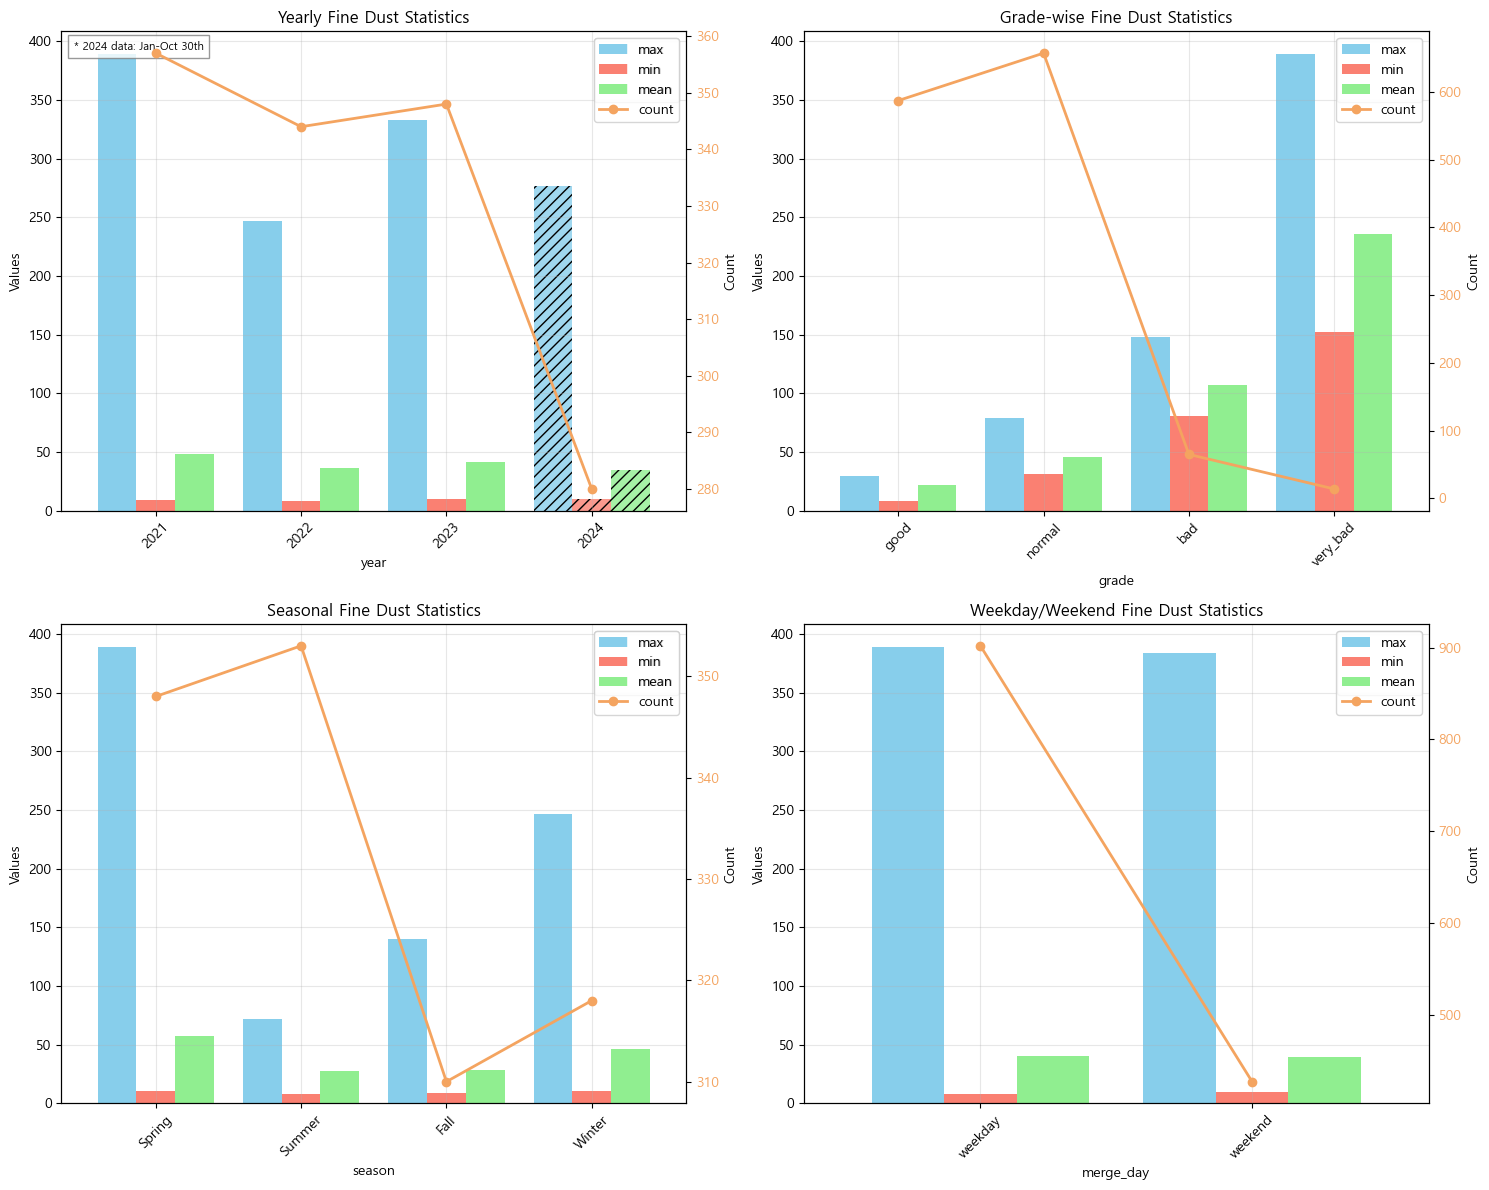

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stats_with_count(stats_df, ax, title):
    """
    Parameters:
        stats_df: 통계치를 포함한 데이터 프레임
        ax: 서브플롯의 축
        title: 그래프 제목
    """
    # 막대 그래프 생성
    bars = stats_df[['max', 'min', 'mean']].plot(kind='bar', ax=ax, 
                                                color=['skyblue', 'salmon', 'lightgreen'],
                                                width=0.8)
    
    # 2024년 막대에 패턴 추가
    if 'year' in str(stats_df.index.name).lower():  # year 관련 그래프인 경우에만
        for container in bars.containers:  # max, min, mean 각각의 막대에 대해
            # 2024년에 해당하는 막대에 패턴 추가
            for idx, patch in enumerate(container):
                if str(stats_df.index[idx]) == '2024':
                    patch.set_hatch('///')
                    patch.set_alpha(0.8)
    
    # 두 번째 y축 생성
    ax2 = ax.twinx()
    
    # count를 선 그래프로 표시
    count_line = ax2.plot(range(len(stats_df)), stats_df['count'], 
                         color='sandybrown', marker='o', linewidth=2, 
                         label='count')
    
    # 첫 번째 축 설정
    ax.set_title(title)
    ax.set_xlabel(stats_df.index.name)
    ax.set_ylabel('Values')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # 두 번째 축 설정
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='y', labelcolor='sandybrown')
    
    # 범례 통합
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + count_line, labels1 + ['count'], 
              loc='upper right')
    
    # 2024년 데이터가 부분적임을 설명하는 주석 추가
    if 'year' in str(stats_df.index.name).lower():
        ax.annotate('* 2024 data: Jan-Oct 30th', 
                   xy=(0.02, 0.98), 
                   xycoords='axes fraction',
                   bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
                   fontsize=8,
                   va='top')

# 서브플롯 생성
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# 각 서브플롯에 그래프 그리기
plot_stats_with_count(df_year_stats, axs[0, 0], 
                     'Yearly Fine Dust Statistics')
plot_stats_with_count(df_grade_stats, axs[0, 1], 
                     'Grade-wise Fine Dust Statistics')
plot_stats_with_count(df_season_stats, axs[1, 0], 
                     'Seasonal Fine Dust Statistics')
plot_stats_with_count(df_day_stats, axs[1, 1], 
                     'Weekday/Weekend Fine Dust Statistics')

# 레이아웃 조정
plt.tight_layout()
plt.show()

In [52]:
# 그래프를 파일로 저장
plt.savefig('./data/Single_Group_Analysis_Plots.png', 
            dpi=300,  # 해상도 설정
            bbox_inches='tight',  # 여백 자동 조정
            pad_inches=0.1)  # 여백 크기

<Figure size 640x480 with 0 Axes>

2. 두 개 변수 조합 분석

In [37]:
# 2-1. 연도와 등급을 조합해서 분석
# 2-2. 연도와 계절을 조합해서 분석
# 2-3. 연도와 평일/주말을 조합해서 분석
# 2-4. 등급과 계절을 조합해서 분석
# 2-5. 등급과 평일/주말을 조합해서 분석
# 2-6. 계절과 평일/주말을 조합해서 분석

3. 세 개 변수 조합 분석

In [ ]:
# 3-1. 연도와 등급과 계절을 조합해서 분석

In [ ]:
# 3-2. 연도와 등급과 평일/주말을 조합해서 분석

In [ ]:
# 3-3. 등급과 계절과 평일/주말을 주합해서 분석

4. 모두 조합 분석

In [ ]:
# 4-1. 연도와 등급과 계절과 평일/주말을 조합해서 분석

In [ ]:
# 그래프 그리기
count_data.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])
plt.title("Fine Dust Level by Weekday and Grade")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# 그래프 그리기
fig, axes = plt.subplots(len(grouped_data.index.levels[0]), 1, figsize=(10, 10), sharex=True)
fig.suptitle("Fine Dust Level by Year, Season, Weekday/Weekend, and Grade")

# 색상 정의 (순서대로 good, normal, bad, very_bad에 대응)
colors = ['lightgreen', 'skyblue', 'salmon', 'orange']

# 각 연도별로 서브플롯에 그래프 생성
for i, (year, data) in enumerate(grouped_data.groupby(level=0)):
    data = data.droplevel(0)  # 연도 레벨 제거
    
    # season_order에 따라 계절 순서 정렬
    data = data.loc[season_order.categories]
    
    # 정의된 순서대로 그래프 그리기
    ax = data.plot(kind='bar', stacked=False, ax=axes[i], color=colors)
    axes[i].set_title(f"{year}년")
    axes[i].set_ylabel("Count")
    
    # x축 레이블 회전 제거
    axes[i].tick_params(axis='x', rotation=0)
    
    # 범례 순서 명시적 지정
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, labels, bbox_to_anchor=(1, 0.8))

plt.xlabel("Season and Grade")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()